In [1]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import pathlib
import gc

In [2]:
preselectionCuts = False
DTF_FixLambda_success = False
save_plots = True

# Import data

In [3]:
inputMC = '~/data/MAGUPDOWN_LHCbMC_Lb2JPsiL_ALL.h5'

In [4]:
tickMC = time.perf_counter()
df_magup = pd.read_hdf(inputMC, key='LHCbMC_MagUp')
tockMC = time.perf_counter()
print(f"MagUp imported in {tockMC - tickMC:0.4f} seconds.")

MagUp imported in 0.4988 seconds.


In [5]:
tickMC = time.perf_counter()
df_magdown = pd.read_hdf(inputMC, key='LHCbMC_MagDown')
tockMC = time.perf_counter()
print(f"MagDown imported in {tockMC - tickMC:0.4f} seconds.")

MagDown imported in 0.4022 seconds.


In [6]:
df_magup['polarity'] = +1
df_magdown['polarity'] = -1

In [7]:
df_MC = pd.concat([df_magup, df_magdown], ignore_index=True)
df_MC

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,Jpsi_ENDVERTEX_X,Jpsi_ENDVERTEX_Y,Jpsi_ENDVERTEX_Z,L_PX,...,MCTRUTH_mup_Reconstructible,MCTRUTH_mum_Reconstructible,MCTRUTH_Lb_Reconstructed,MCTRUTH_L_Reconstructed,MCTRUTH_p_Reconstructed,MCTRUTH_pim_Reconstructed,MCTRUTH_Jpsi_Reconstructed,MCTRUTH_mup_Reconstructed,MCTRUTH_mum_Reconstructed,polarity
0,0.531989,0.156184,-11.605191,-990.557041,-155.257567,7681.106228,0.5413,0.1391,-11.7045,-2907.631194,...,2,2,0,0,4,4,0,1,1,1
1,0.528757,-0.070308,-0.085964,-180.519168,-133.057595,7569.258412,0.5293,-0.0706,-0.0969,-1120.822842,...,2,2,0,0,4,4,0,1,1,1
2,0.859428,-0.376049,29.521646,-82.626349,-331.621786,4814.597517,0.8603,-0.3764,29.5380,575.017171,...,2,2,0,0,4,4,0,1,1,1
3,0.933587,-0.165953,-28.980723,113.230367,-74.224539,4443.563975,0.9336,-0.1660,-28.9808,3718.929704,...,2,2,0,0,4,4,0,1,1,1
4,0.836371,-0.127803,-36.125244,128.102391,-220.857899,4732.615341,0.8364,-0.1278,-36.1245,4125.442640,...,2,2,0,0,4,4,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366391,1.280367,-0.186221,-31.547196,894.704440,-344.928098,7130.349351,1.2804,-0.1862,-31.5470,7387.348571,...,2,2,0,0,4,4,0,1,1,-1
366392,1.271159,-0.350343,6.626092,336.167222,-21.463709,5906.546731,1.2705,-0.3499,6.6130,4606.784224,...,2,2,0,0,4,4,0,1,1,-1
366393,0.949503,0.372691,38.086360,158.187917,386.794126,3645.829919,0.9495,0.3727,38.0864,2568.751484,...,2,2,0,0,4,4,0,1,1,-1
366394,0.667880,-0.200282,31.615003,-149.923019,18.522700,7679.417786,0.6673,-0.2004,31.6097,-2221.075252,...,2,2,0,0,4,4,0,1,1,-1


In [8]:
## Cleanup
try:
    del(df_magup)
except NameError:
    pass

try:
    del(df_magdown)
except NameError:
    pass

gc.collect()

0

In [9]:
def MomentumModulus(px, py, pz):
    return np.sqrt(px**2 + py**2 + pz**2)

def TransverseMomentumModulus(px, py):
    return np.sqrt(px**2 + py**2)

In [10]:
if preselectionCuts:
    JPsi1SPDGMass = 3096.900

    PionPCuts = (MomentumModulus(df_MC['pim_PX'], df_MC['pim_PY'], df_MC['pim_PZ']) > 2000) & (MomentumModulus(df_MC['pim_PX'], df_MC['pim_PY'], df_MC['pim_PZ']) < 5e5)
    ProtonPCuts = (MomentumModulus(df_MC['p_PX'], df_MC['p_PY'], df_MC['p_PZ']) > 10000) & (MomentumModulus(df_MC['p_PX'], df_MC['p_PY'], df_MC['p_PZ']) < 5e5)
    ProtonPTCuts = TransverseMomentumModulus(df_MC['p_PX'], df_MC['p_PY']) > 400
    LambdaMCuts = (df_MC['L_M'] > 600) & (df_MC['L_M'] < 1500)
    LambdaMMCuts = df_MC['L_MM'] < 1500
    LambdaZCuts = (df_MC['L_ENDVERTEX_Z'] > 5500) & (df_MC['L_ENDVERTEX_Z'] < 8500)
    LambdaDiraCuts = (df_MC['L_BPVDIRA'] > 0.9999)
    LambdaBPVIPCHI2Cuts = df_MC['L_BPVIPCHI2'] < 200
    LambdaBPVVDCHI2Cuts = df_MC['L_BPVVDCHI2'] < 2e7
    LambdaChi2Cuts = df_MC['L_VFASPF_CHI2_VDOF'] < 750
    JPsiMCuts = abs(df_MC['Jpsi_M'] - JPsi1SPDGMass) < 90
    LambdaPTCuts = TransverseMomentumModulus(df_MC['L_PX'], df_MC['L_PY']) > 450
    LambdabMCuts = (df_MC['Lb_M'] < 8500)
    LambdabDiraCuts = abs(df_MC['Lb_BPVDIRA']) > 0.99
    LambdabBPVIPCHI2Cuts = df_MC['Lb_BPVIPCHI2'] < 1750
    LambdabChi2Cuts = df_MC['Lb_VFASPF_CHI2_VDOF'] < 150

    df_MC = df_MC.loc[
        PionPCuts &
        ProtonPCuts &
        ProtonPTCuts &
        LambdaMCuts &
        LambdaMMCuts &
        LambdaZCuts &
        LambdaDiraCuts &
        LambdaBPVIPCHI2Cuts &
        LambdaBPVVDCHI2Cuts &
        LambdaChi2Cuts &
        JPsiMCuts &
        LambdaPTCuts &
        LambdabMCuts &
        LambdabDiraCuts &
        LambdabBPVIPCHI2Cuts &
        LambdabChi2Cuts
    ]
    
    if DTF_FixLambda_success:
        DTFCuts = (df_MC['DTF_FixJPsiLambda_status'] == 'Success')
        df_MC = df_MC.loc[DTFCuts]

# Search for asymmetries

## Plot settings

In [11]:
## Create plots directory, if missing
plotsDirectory = (str(pathlib.Path.home())
                  + '/vertex-reconstruction-studies/plots/studies_on_full_data/'
                  + 'decay_reconstruction_asymmetry_analysis/')
pathlib.Path(plotsDirectory).mkdir(parents=True, exist_ok=True)

## Colors
fullColor = 'grey'
matterColor = 'tab:red'
antimatterColor = 'tab:green'

In [12]:
## series: a pandas.Series to plot, e.g. a column of a data frame
## matterCharge: either 'matter', 'antimatter' or 'both'
## polarity: either +1 or -1 (up and down respectively) or 'both'
## plotTitle: title of the plot (no way)
## seriesLabel: the label for the x-axis
## seriesFileName: the name of the plot file (after prefixes)
## binning: no. of bins.
## boundaries: range of the histogram (2-ple)
## scale: argument for plt.yscale()
## scientificNotation: if True, use scientific notation for x axis
def PlotSingleHistogram(
    series,
    matterCharge,
    polarity,
    plotTitle,
    seriesLabel,
    seriesFileName,
    binning,
    boundaries,
    scale='linear',
    scientificNotation=False
):
    
    if matterCharge == 'matter':
        matterChargeCut = (df_MC['p_ID'] == 2212)
        customColor = matterColor
        matterSubtitle = "Only $\Lambda_b$ decays"
        matterPrefix = 'matter'
    elif matterCharge == 'antimatter':
        matterChargeCut = (df_MC['p_ID'] == -2212)
        customColor = antimatterColor
        matterSubtitle = "Only anti-$\Lambda_b$ decays"
        matterPrefix = 'antimatter'
    elif matterCharge == 'both':
        matterChargeCut = (pd.Series(True,index=df_MC.index))
        customColor = fullColor
        matterSubtitle = "$\Lambda_b$ + anti-$\Lambda_b$ decays"
        matterPrefix = 'allmatter'
    else:
        raise ValueError("Argument matterCharge must be either 'matter', 'antimatter' or 'both'.")
        
    if polarity == 'both':
        polarityCut = (pd.Series(True,index=df_MC.index))
        polaritySubtitle = "MagUp & MagDown"
        polarityPrefix = 'MagUpDown'
    elif polarity in [1,-1]:
        polarityCut = (df_MC['polarity'] == polarity)
        if polarity == 1:
            polaritySubtitle = "MagUp only"
            polarityPrefix = 'MagUp'
        else:
            polaritySubtitle = "MagDown only"
            polarityPrefix = 'MagDown'
    else:
        raise ValueError("Argument polarity must be either +1, -1, or 'both'.")
    
    variables = series.loc[matterChargeCut & polarityCut]
    
    plt.hist(variables,
             bins=binning,
             range=boundaries,
             histtype='stepfilled',
             edgecolor=customColor,
             color=mcolors.to_rgba(customColor, alpha=0.1)
    )
    
    plt.axvline(x=0,ymin=0,ymax=10000,linestyle='--',color='k')
    
    plt.grid()
    plt.xlabel(seriesLabel)
    plt.title(plotTitle + "\n" + "(" + matterSubtitle + ", " + polaritySubtitle + ")")
    plt.yscale(scale)
    plt.ylabel("Events")
    if scientificNotation:
        plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    if save_plots:
        plt.savefig(plotsDirectory + matterPrefix + "_" + polarityPrefix + "_" + seriesFileName + '.pdf', bbox_inches='tight')
    plt.show()

## Proton momentum

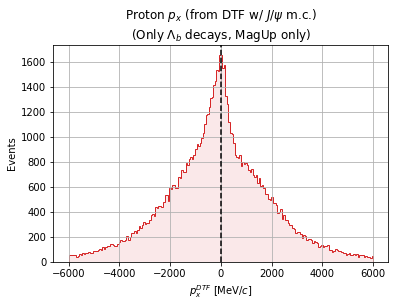

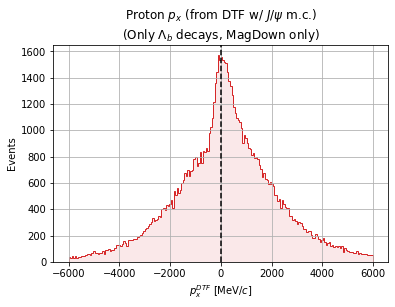

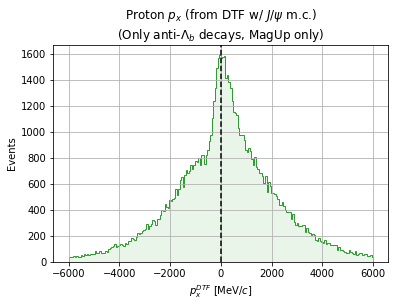

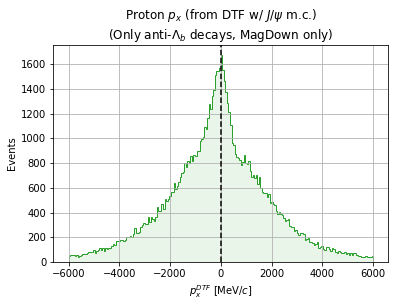

In [13]:
for matterCharge in ['matter', 'antimatter']:
    for polarity in [+1, -1]:
        plotArgs = {
            "matterCharge": matterCharge,
            "polarity": polarity,
            "seriesLabel": "$p_x^{DTF}$ [MeV/$c$]",
            "plotTitle": "Proton $p_x$ (from DTF w/ $J/\psi$ m.c.)",
            "seriesFileName": "p_PX_DTF",
            "scale": "linear",
            "binning": 200,
            "boundaries": (-6000,6000),
            "scientificNotation": False    
        }
        
        PlotSingleHistogram(df_MC['DTF_FixJPsi_p_PX'], **plotArgs)
#PlotOverlappingHistograms(**plotArgs)

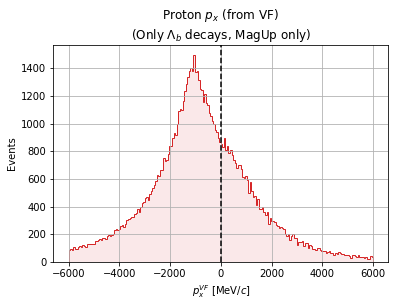

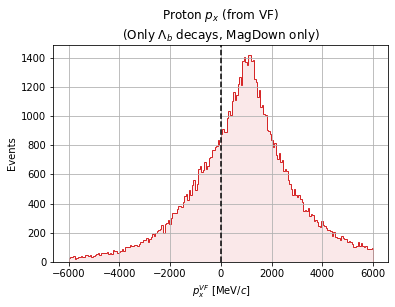

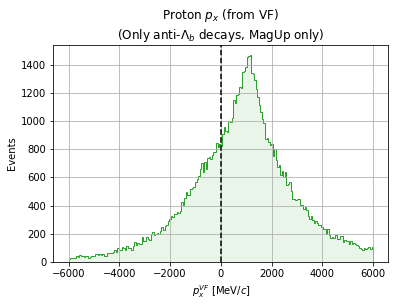

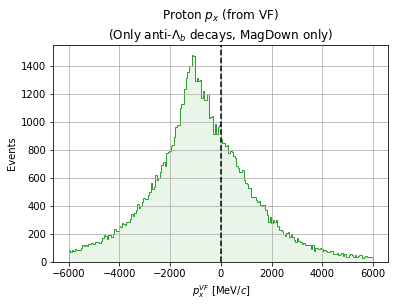

In [14]:
for matterCharge in ['matter', 'antimatter']:
    for polarity in [+1, -1]:
        plotArgs = {
            "matterCharge": matterCharge,
            "polarity": polarity,
            "seriesLabel": "$p_x^{VF}$ [MeV/$c$]",
            "plotTitle": "Proton $p_x$ (from VF)",
            "seriesFileName": "p_PX_VF",
            "scale": "linear",
            "binning": 200,
            "boundaries": (-6000,6000),
            "scientificNotation": False    
        }
        
        PlotSingleHistogram(df_MC['p_PX'], **plotArgs)
#PlotOverlappingHistograms(**plotArgs)

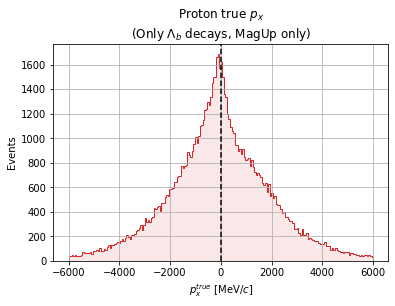

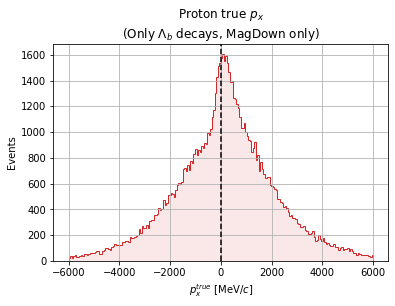

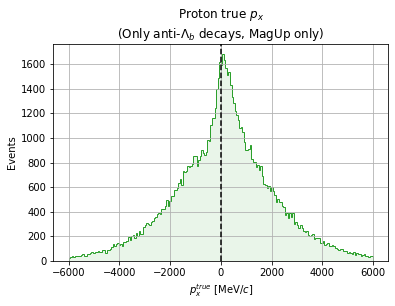

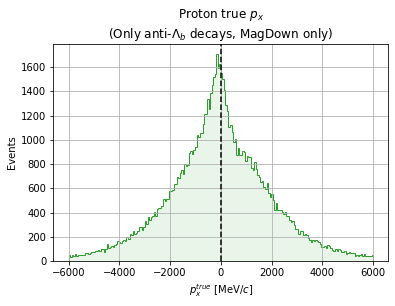

In [15]:
for matterCharge in ['matter', 'antimatter']:
    for polarity in [+1, -1]:
        plotArgs = {
            "matterCharge": matterCharge,
            "polarity": polarity,
            "seriesLabel": "$p_x^{true}$ [MeV/$c$]",
            "plotTitle": "Proton true $p_x$",
            "seriesFileName": "p_PX_MCTRUTH",
            "scale": "linear",
            "binning": 200,
            "boundaries": (-6000,6000),
            "scientificNotation": False    
        }
        
        PlotSingleHistogram(df_MC['MCTRUTH_p_PX'], **plotArgs)
#PlotOverlappingHistograms(**plotArgs)

## Horizontality

(Note: a far more polished version of the following study was conducted in the `preliminary-variable-studies` repository, as part of the $\Lambda^0$ vertex bias analysis. Long story short: there is some significant bias when considering events reconstructed as "upside down", but it doesn't appear related to the asymmetries seen above.)

In [16]:
def RowAVec(row, p_pvec_column, pim_pvec_column):
    return np.cross(row[p_pvec_column], row[pim_pvec_column])

def RowANorm(row, avec_column):
    return np.linalg.norm(row[avec_column])

In [17]:
def Feature1DComponent(series, component):
    return series.map(lambda x: x[component])

In [18]:
## This computes (once) a new column in df named 'momentaPrefix_h',
## containing the related horizontality. Returns the related column.
def ComputeHorizontality(
    df,
    momentaPrefix,
    p_px_column,
    p_py_column,
    p_pz_column,
    pim_px_column,
    pim_py_column,
    pim_pz_column,
):
      
    p_pvec_column = momentaPrefix + "_p_p_vec"
    pim_pvec_column = momentaPrefix + "_pim_p_vec"
    avec_column = momentaPrefix + "_a_vec"
    anorm_column = momentaPrefix + "_a_norm"
    ahat_column = momentaPrefix + "_a_hat"
    h_column = momentaPrefix + "_h"
    
    df[p_pvec_column] = list(zip(df[p_px_column], df[p_py_column], df[p_pz_column]))
    df[pim_pvec_column] = list(zip(df[pim_px_column], df[pim_py_column], df[pim_pz_column]))
    df[avec_column] = df.apply(lambda row: RowAVec(row, p_pvec_column, pim_pvec_column), axis=1)
    df[anorm_column] = df.apply(lambda row: RowANorm(row, avec_column), axis=1)
    df[ahat_column] = df[avec_column]/df[anorm_column]
    df[h_column] = Feature1DComponent(df[ahat_column], 1) * df['polarity'] * np.sign(df['L_ID'])
    
    df.drop(columns=[
        p_pvec_column,
        pim_pvec_column,
        avec_column,
        anorm_column,
        ahat_column
    ])
    
    return h_column

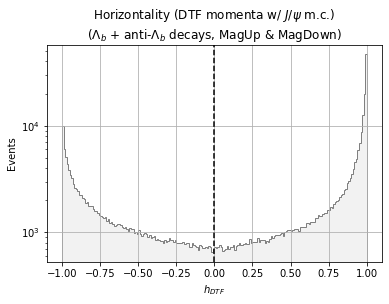

In [19]:
h_column = ComputeHorizontality(
    df_MC, "DTF_FixJPsi",
    'DTF_FixJPsi_p_PX', 'DTF_FixJPsi_p_PY', 'DTF_FixJPsi_p_PZ',
    'DTF_FixJPsi_pim_PX', 'DTF_FixJPsi_pim_PY', 'DTF_FixJPsi_pim_PZ',
)

plotArgs = {
    "matterCharge": 'both',
    "polarity": 'both',
    "seriesLabel": "$h_{DTF}$",
    "plotTitle": "Horizontality (DTF momenta w/ $J/\psi$ m.c.)",
    "seriesFileName": "horizontality_DTF",
    "scale": "log",
    "binning": 200,
    "boundaries": (-1,1),
    "scientificNotation": False    
}
       
PlotSingleHistogram(df_MC[h_column], **plotArgs)

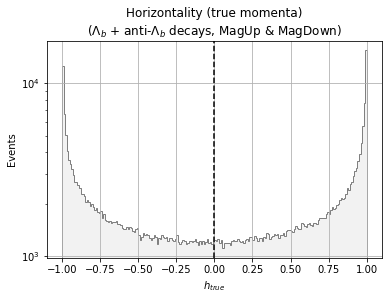

In [20]:
h_column = ComputeHorizontality(
    df_MC, "MCTRUTH",
    'MCTRUTH_p_PX', 'MCTRUTH_p_PY', 'MCTRUTH_p_PZ',
    'MCTRUTH_pim_PX', 'MCTRUTH_pim_PY', 'MCTRUTH_pim_PZ',
)

plotArgs = {
    "matterCharge": 'both',
    "polarity": 'both',
    "seriesLabel": "$h_{true}$",
    "plotTitle": "Horizontality (true momenta)",
    "seriesFileName": "horizontality_MCTRUTH",
    "scale": "log",
    "binning": 200,
    "boundaries": (-1,1),
    "scientificNotation": False    
}
       
PlotSingleHistogram(df_MC[h_column], **plotArgs)

In [21]:
def CountEventAsymmetry(series, threshold, p_ID_sign, polarity):
    filteredSeries = series.loc[(np.sign(df_MC['p_ID']) == p_ID_sign) & (df_MC['polarity'] == polarity)]
    totEvts = len(filteredSeries)
    posEvts = sum(filteredSeries >= threshold)
    negEvts = sum(filteredSeries < threshold)
    return abs(posEvts - negEvts)

In [22]:
def CountAsymmetryAcrossPIDAndPolarity(series, threshold):
    tot = 0
    for polarity in [+1,-1]:
        for p_ID_sign in [+1,-1]:
            tot += CountEventAsymmetry(series, threshold, p_ID_sign, polarity)
            
    return tot

In [23]:
CountAsymmetryAcrossPIDAndPolarity(df_MC['DTF_FixJPsi_p_PX'],0)

29166

In [24]:
CountAsymmetryAcrossPIDAndPolarity(df_MC['MCTRUTH_p_PX'],0)

27638

These are roughly the same, as expected.

In [25]:
CountAsymmetryAcrossPIDAndPolarity(df_MC['DTF_FixJPsi_h'],0)

81298

In [26]:
CountAsymmetryAcrossPIDAndPolarity(df_MC['MCTRUTH_h'],0)

7592

These are not only vastly different, but also vastly different from the momenta discrepancies. Are we sure we're not doing something wrong?

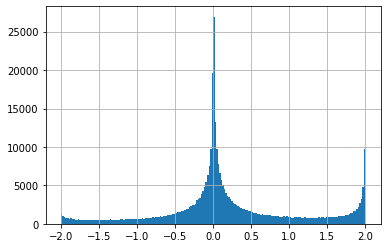

In [27]:
plt.hist(df_MC['DTF_FixJPsi_h'] - df_MC['MCTRUTH_h'],bins=200)
plt.grid()
plt.show()

In [28]:
CountAsymmetryAcrossPIDAndPolarity(df_MC['DTF_FixJPsi_h'] - df_MC['MCTRUTH_h'],0)

66698

So that's how many events are reconstructed "upside down", so to speak.

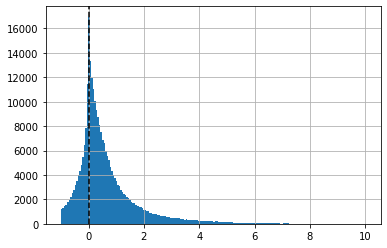

In [29]:
df_MC_horizontalityFilter = df_MC.loc[df_MC['DTF_FixJPsi_h'] - df_MC['MCTRUTH_h'] <= 1.]

plt.hist(
    (df_MC_horizontalityFilter['L_ENDVERTEX_Z'] - df_MC_horizontalityFilter['MCTRUTH_L_ENDVERTEX_Z'])/1000,
    bins=200,
    range=(-1,10)
)
plt.axvline(0,0,1e6,linestyle='--', color='k')
plt.grid()
plt.show()

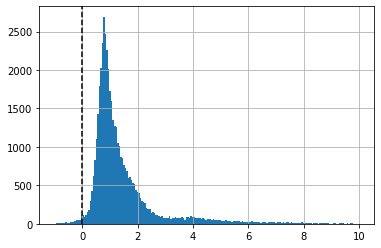

In [30]:
df_MC_horizontalityFilter = df_MC.loc[df_MC['DTF_FixJPsi_h'] - df_MC['MCTRUTH_h'] >= 1.5]

plt.hist(
    (df_MC_horizontalityFilter['L_ENDVERTEX_Z'] - df_MC_horizontalityFilter['MCTRUTH_L_ENDVERTEX_Z'])/1000,
    bins=200,
    range=(-1,10)
)
plt.axvline(0,0,1e6,linestyle='--', color='k')
plt.grid()
plt.show()

So yeah, sure, these events are those for which the $z$ is more heavily biased, i.e. the ghost vertex is chosen for reconstruction.

This tells us nothing on the failed events, though.